# Machine Learned Potentials with IPSuite

## Installation

We will install IPSuite and its dependencies for this Project from the `requirements.txt` file

In [1]:
!pip install -r requirements.txt

DEPRECATION: git+https://github.com/zincware/ipsuite.git#egg=ipsuite[gap] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/zincware/ipsuite.git to /tmp/pip-install-gku61j67/ipsuite_9c2196a927ac4ea69d65e63fb2a59a91
  Running command git clone --filter=blob:none --quiet https://github.com/zincware/ipsuite.git /tmp/pip-install-gku61j67/ipsuite_9c2196a927ac4ea69d65e63fb2a59a91
  Resolved https://github.com/zincware/ipsuite.git to commit 38b6bf7538d44ebf5a0d6fd932da05a5a204ee28
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/ACEsuit/mace.git to /tmp/pip-install-gku61j67/mace_478ee58633674a2fab559990c41d0c8c
  Running command git clone --filter=blob:none -

## Fitting a Potential

The following Code describes the generation of training data and fitting a GAP potential.
[![](https://mermaid.ink/img/pako:eNqllFFvgjAQx7-Kqa9qhigiD0vcNM5MJll5GwtpaNHGQg2UOWP87isbaCx1WTKeLv__r3fc9dIjiDgmwAEx4_togzLRWr4Gaav6UmkabwGYwNmc8NVOBOD92u3_uO604Zi1ExoNb3DxQrEhWcJzgZrJh2fsF8iS0KPXf4Y0XTPicZo2mVHJ8DSm6yJDgvIUEkaiMmig9k1U08dYwnP_KXyYwAUM4cyHPfwRNTDjruK8lT978ReT5Q2unLW7dGXImmY5ag9F24RrzHLaXkYw1XdlDK58l4iMRnkTKycOE8pI7vOJ4IkGKeeNY4HNHkZC30a3e_-9G3rZVDaokkd62VY2R59kqC9pVbKhlxV6pC9Zy4ZS0651Jfu40i11CW7oN-Zy1tW6Rl_f1VlXC5g1P1BvuzbUm7IumS5OLg6MVL_WiiljTjsex51cZHxLnLZpmlXc3VMsNs5g96k7bP7jrP3Hs6ADEvlgIIrl03YsMwVAPiEJCYAjQ0xiVDD5TATpSaKoEBwe0gg4IitIBxQ7udlkStE6QwlwYsRycvoCcbuCGw?type=png)](https://mermaid.live/edit#pako:eNqllFFvgjAQx7-Kqa9qhigiD0vcNM5MJll5GwtpaNHGQg2UOWP87isbaCx1WTKeLv__r3fc9dIjiDgmwAEx4_togzLRWr4Gaav6UmkabwGYwNmc8NVOBOD92u3_uO604Zi1ExoNb3DxQrEhWcJzgZrJh2fsF8iS0KPXf4Y0XTPicZo2mVHJ8DSm6yJDgvIUEkaiMmig9k1U08dYwnP_KXyYwAUM4cyHPfwRNTDjruK8lT978ReT5Q2unLW7dGXImmY5ag9F24RrzHLaXkYw1XdlDK58l4iMRnkTKycOE8pI7vOJ4IkGKeeNY4HNHkZC30a3e_-9G3rZVDaokkd62VY2R59kqC9pVbKhlxV6pC9Zy4ZS0651Jfu40i11CW7oN-Zy1tW6Rl_f1VlXC5g1P1BvuzbUm7IumS5OLg6MVL_WiiljTjsex51cZHxLnLZpmlXc3VMsNs5g96k7bP7jrP3Hs6ADEvlgIIrl03YsMwVAPiEJCYAjQ0xiVDD5TATpSaKoEBwe0gg4IitIBxQ7udlkStE6QwlwYsRycvoCcbuCGw)

For this exercise we will only focus on the highlighted Nodes. You will make some modifications to the ML model.


In [1]:
import ipsuite as ips

2023-05-12 16:22:09,246 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [2]:
mapping = ips.geometry.BarycenterMapping(data=None)
thermostat = ips.calculators.LangevinThermostat(
    temperature=300, friction=0.01, time_step=0.5
)

with ips.Project(automatic_node_names=True) as project:
    mol = ips.configuration_generation.SmilesToAtoms(smiles="O")

    packmol = ips.configuration_generation.Packmol(
        data=[mol.atoms], count=[10], density=997
    )

    cp2k = ips.calculators.CP2KSinglePoint(
        data=packmol,
        cp2k_files=["GTH_BASIS_SETS", "GTH_POTENTIALS", "dftd3.dat"],
        cp2k_shell="cp2k_shell.psmp",
    )

    geopt = ips.calculators.ASEGeoOpt(
        model=cp2k,
        data=packmol.atoms,
        optimizer="BFGS",
        run_kwargs={"fmax": 0.1},
    )

    md = ips.calculators.ASEMD(
        model=cp2k,
        thermostat=thermostat,
        data=geopt.atoms,
        data_id=-1,
        sampling_rate=1,
        dump_rate=1,
        steps=5000,
    )

    test_data = ips.configuration_selection.RandomSelection(
        data=md, n_configurations=250
    )
    train_data = ips.configuration_selection.RandomSelection(
        data=md,
        n_configurations=250,
        exclude_configurations=[
            test_data.selected_configurations,
        ],
    )

    model = ips.models.GAP(data=train_data, soap={"cutoff": 3, "l_max": 5, "n_max": 5})

    predictions = ips.analysis.Prediction(data=test_data, model=model)
    analysis = ips.analysis.PredictionMetrics(data=predictions)

    ml_md = ips.calculators.ASEMD(
        model=model,
        thermostat=thermostat,
        data=geopt.atoms,
        data_id=-1,
        sampling_rate=1,
        dump_rate=1,
        steps=5000,
    )

project.run(repro=False)

Running DVC command: 'stage add --name SmilesToAtoms --force ...'
Running DVC command: 'stage add --name Packmol --force ...'
Running DVC command: 'stage add --name CP2KSinglePoint --force ...'
Running DVC command: 'stage add --name ASEGeoOpt --force ...'
Running DVC command: 'stage add --name ASEMD --force ...'
Running DVC command: 'stage add --name ASEMD_thermostat --force ...'
Running DVC command: 'stage add --name ConfigurationSelection --force ...'
Running DVC command: 'stage add --name ConfigurationSelection_1 --force ...'
Running DVC command: 'stage add --name MLModel --force ...'
Running DVC command: 'stage add --name Prediction --force ...'
Running DVC command: 'stage add --name PredictionMetrics --force ...'
Running DVC command: 'stage add --name ASEMD_1 --force ...'
Running DVC command: 'stage add --name ASEMD_1_thermostat --force ...'


## Download the ML model

In [ ]:
!dvc pull

# Analyse the results

We downloaded a pre-trained ML Model and small MD trajectory. The following code will load the data into Python and Plot a Radial Distribution Function of the ML Potential and the DFT MD.

In [3]:
analysis.load()

In [4]:
analysis.energy

{'rmse': 0.07039366374405535,
 'mae': 0.05435766227467684,
 'max': 0.23968925825647602,
 'lp4': 0.001518789890950317,
 'rrmse': 0.3431523337839232}

In [5]:
analysis.forces

{'rmse': 0.2166849643939525,
 'mae': 0.16563709210143565,
 'max': 1.3308658904833228,
 'lp4': 0.0003829747931285688,
 'rrmse': 0.4034497611397265}

In [6]:
analysis.energy_df.iloc[:5]

,Unnamed: 0,true,prediction
0,0,-4488.628885,-4488.559935
1,1,-4488.916983,-4488.856999
2,2,-4488.952904,-4488.906169
3,3,-4488.910617,-4488.908044
4,4,-4488.903727,-4488.867146


The following correlation plots was also generated automatically and might help you evaluating the ML Model accuracy.

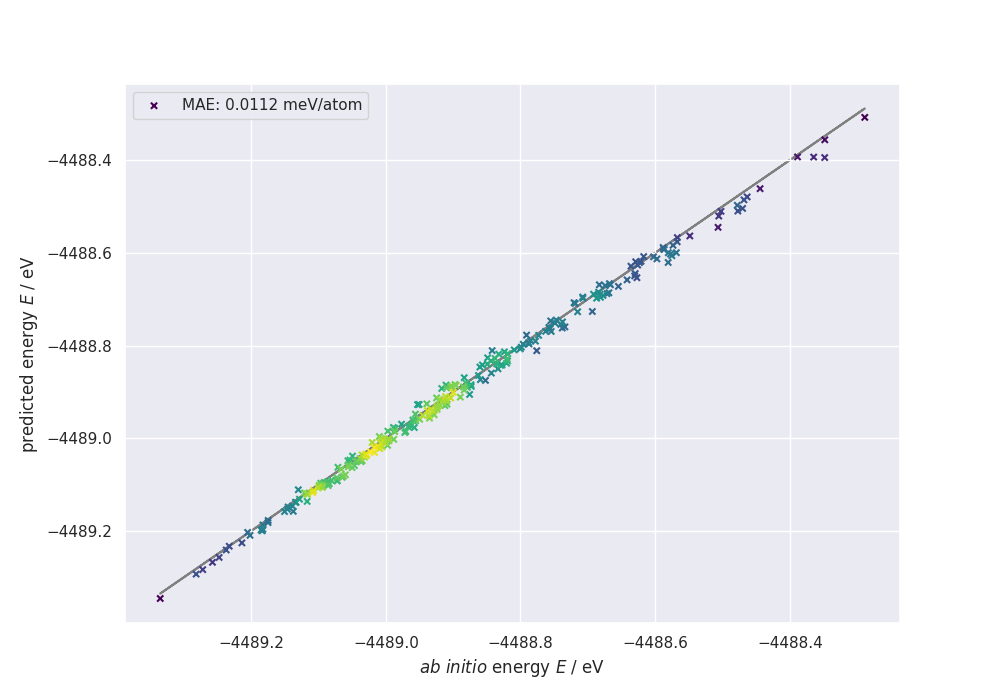

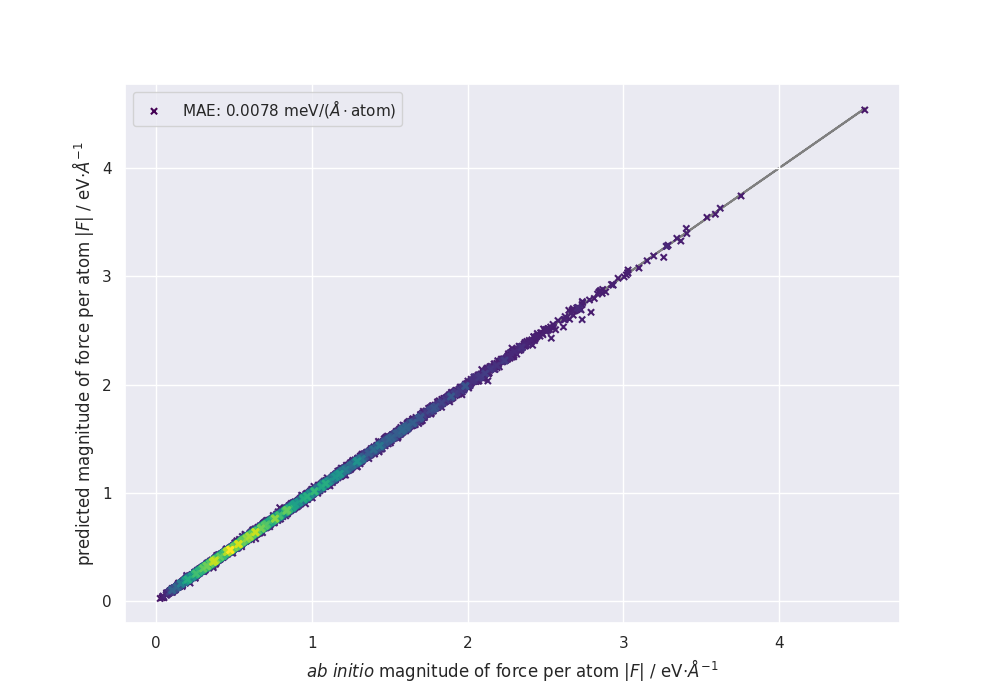

In [10]:
from IPython.display import display, Image, display_pretty, Pretty
display(Image(filename='nodes/PredictionMetrics/plots/energy.png'))
display(Image(filename='nodes/PredictionMetrics/plots/forces.png'))

### DFT DATA

In [7]:
md.load()
md.atoms[:5]

[Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...))]

## Simulation Data

In [8]:
ml_md.load()
ml_md.atoms[:5]

[Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...))]

## Compute RDF

In [9]:
import ase
import ase.geometry.analysis
import matplotlib.pyplot as plt
import numpy as np

In [10]:
data = ase.geometry.analysis.Analysis(ml_md.atoms).get_rdf(rmax=3.0, nbins=100, elements=["H", "O"])
dft_data = ase.geometry.analysis.Analysis(md.atoms).get_rdf(rmax=3.0, nbins=100, elements=["H", "O"])

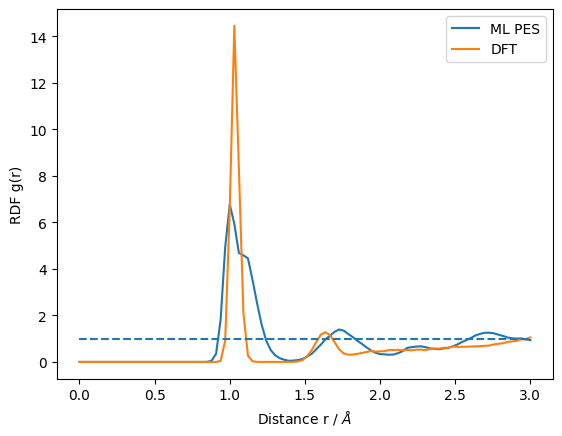

In [12]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, 3.0, 100), np.mean(data, axis=0), label="ML PES")
ax.plot(np.linspace(0, 3.0, 100), np.mean(dft_data, axis=0), label="DFT")
ax.hlines(xmin=0, xmax=3, y=1, ls="--")
ax.set_xlabel(r"Distance r / $\AA$")
ax.set_ylabel("RDF g(r)")
ax.legend()

## Fit your own ML model

Now that we have looked at a pretrained model, it is time to optimize the parameters and train a new Model.
Please edit the `params.yaml` file and adjust:
- `ConfigurationSelection_1.n_configurations` to change the number of training configurations
- `MLModel.soap.cutoff`, `MLModel.soap.l_max` and `MLModel.soap.n_max` to change the parameters of the ML Model
- `ASEMD_1_thermostat` and `ASEMD_1` to update the MD parameter.


After you made your changes run the next cell containing `dvc repro` to train your model.
> This will run `dvc repro` in the terminal.

In [11]:
display(Pretty(filename="params.yaml"))

ASEGeoOpt:
    data_id: 0
    init_kwargs: {}
    optimizer: BFGS
    repeat:
    - 1
    - 1
    - 1
    run_kwargs:
        fmax: 0.1
ASEMD:
    data_id: -1
    dump_rate: 1
    init_temperature: null
    init_velocity: null
    repeat:
    - 1
    - 1
    - 1
    sampling_rate: 1
    steps: 5000
ASEMD_1:
    data_id: -1
    dump_rate: 1
    init_temperature: null
    init_velocity: null
    repeat:
    - 1
    - 1
    - 1
    sampling_rate: 1
    steps: 5000
ASEMD_1_thermostat:
    friction: 0.01
    temperature: 300
    time_step: 0.5
ASEMD_thermostat:
    friction: 0.01
    temperature: 300
    time_step: 0.5
ConfigurationSelection:
    n_configurations: 250
    seed: 1234
ConfigurationSelection_1:
    n_configurations: 250
    seed: 1234
ConfigurationSelection_2:
    n_configurations: 250
    seed: 1234
MLModel:
    distance_nb:
        _type: distanceNb_dataclass
        value:
            add_species: true
            covariance_type: ard_se
            cutoff: 6.0
            

In [ ]:
!dvc repro

## Analyse your model

Copy and paste the code from the **Analyse the Results** section above and evaluate your model. Start at `analysis.load()`.

You can continue changing parameters and running the `dvc repro` cell and the analysis and compare multiple models

In [ ]:
analysis.load()
ml_md.load()
# ...

# More accuracy

You have used the GAP model up until now.
For the last part we will have a look at another ML Model, called MACE https://github.com/ACEsuit/mace

For this example training a MACE model takes longer than training a GAP model.
Therefore, we will look at a pretrained model that we can download.

We will save our current model and load the MACE model afterwards.

In [6]:
!git add .
!git commit -m "new ML Model"

[main 4b07b60] new ML Model
 3 files changed, 1031 insertions(+), 20 deletions(-)
 create mode 100644 .ipynb_checkpoints/main-checkpoint.ipynb


In [7]:
!git checkout mace

Branch 'mace' set up to track remote branch 'mace' from 'origin'.
Switched to a new branch 'mace'


In [8]:
!dvc pull

  0% Transferring|                                   |0/1 [00:00<?,     ?file/s]
!
  0%|          |https://dagshub.com/PythonFZ/IPS-Wa0.00/? [00:00<?,        ?B/s]
100% Transferring|███████████████████████████████|1/1 [00:00<00:00,  5.71file/s]
name: None, md5: c766ffc4f98d49ad1a7f8a54699b579d.dir
name: nodes/PredictionMetrics/stress_df.csv, md5: aa88768760db1fc397812f7595cef752
name: nodes/Prediction/atoms.h5, md5: 49ae08fca996bbf4bb912a8d1def2639
name: nodes/PredictionMetrics/energy_df.csv, md5: c6702591e1e06cad29fe7d82d693b96d
name: nodes/PredictionMetrics/forces_df.csv, md5: 001255ce1b8e555e21b960a3be5512a5
  0% Transferring|                                  |0/18 [00:00<?,     ?file/s]
!
  0%|          |https://dagshub.com/PythonFZ/IPS-Wa0.00/? [00:00<?,        ?B/s]
  0%|          |https://dagshub.com/PythonFZ/IPS-Wa0.00/? [00:00<?,        ?B/s]
  0%|          |https://dagshub.com/PythonFZ/IP161k/? [00:00<00:00,    1.64MB/s]
  0%|          |https://dagshub.com/PythonFZ/I4.17M/? [

The following images show the correlation plots of the MACE model.
How much do they differ from your best GAP model?
Copy and paste the code from the **Analyse the Results** section above again and evaluate your model.
Because we are using MACE instead of GAP we need to change the Model via `model = ips.models.MACE.from_rev()`.
Especially compare the RDF of the MACE model with your GAP model.

In [15]:
model = ips.models.MACE.from_rev()

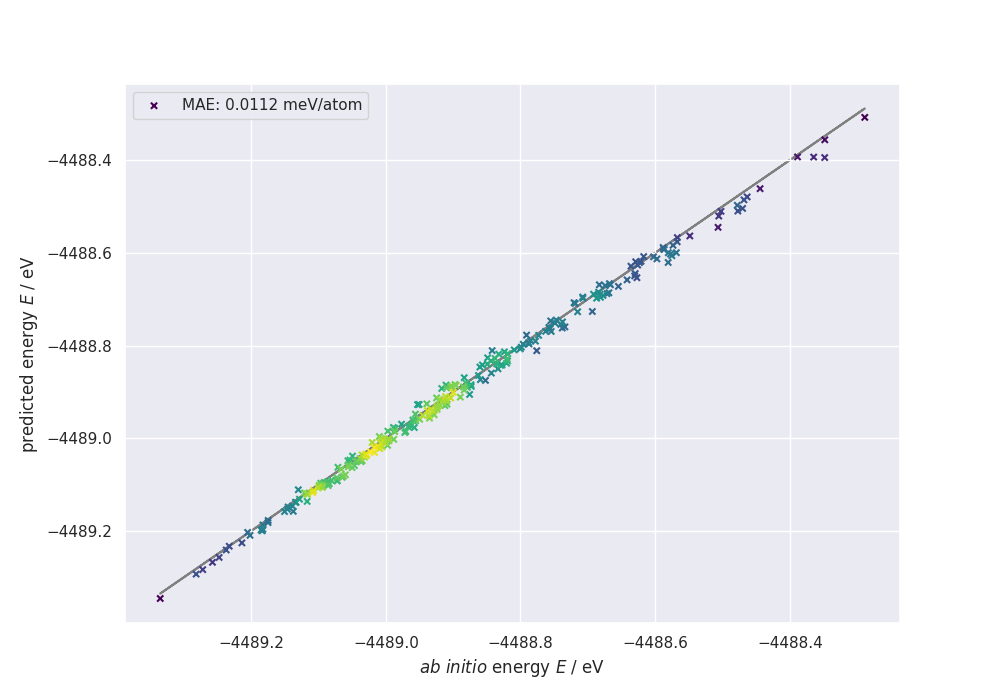

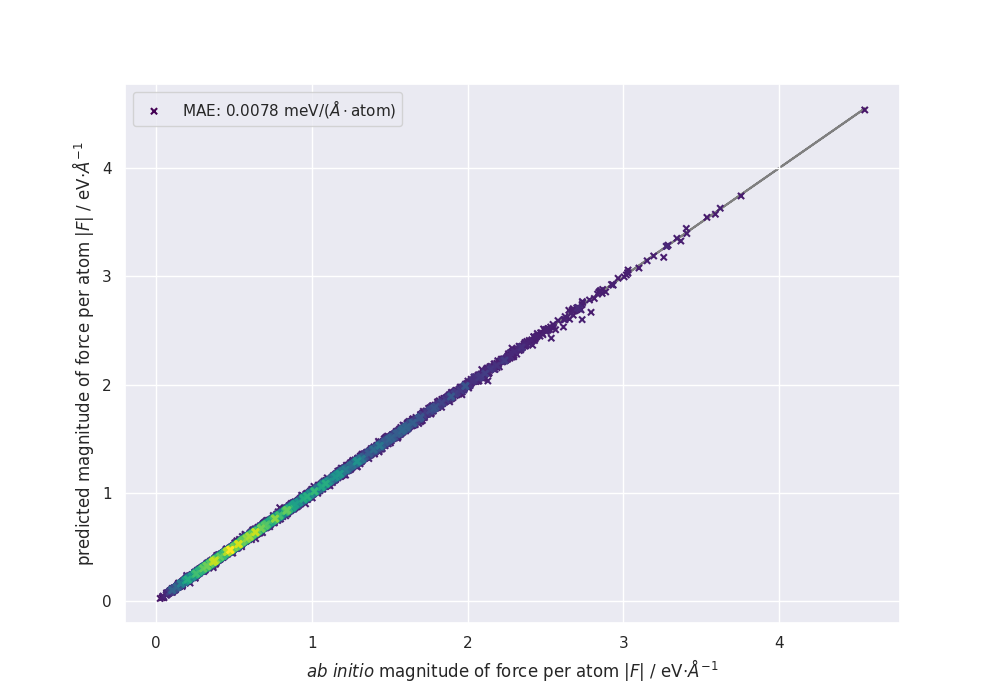

In [16]:
display(Image(filename='nodes/PredictionMetrics/plots/energy.png'))
display(Image(filename='nodes/PredictionMetrics/plots/forces.png'))

# Return to your model

In [ ]:
!git checkout main
!dvc checkout